In [1]:
# general
import datetime as dt

# data handling
import numpy as np
import pandas as pd

# plotting
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# forecasting
import fbprophet as prophet

# from imports
from plotly.tools import FigureFactory as FF
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot  # for offline use
from pandas.io import gbq

from typing import Union, Optional

from query import Query  # custom -> export PYTHONPATH=/path/to/query.py
from tools import read_ts, bounded_graph  # externalized 

# run plotly offline and initialize notebook plotting
init_notebook_mode(connected=True)

In [2]:
# matplotlib: setup of figure parameters
rcParams = {"axes.labelsize": 15,
            "axes.titlesize": 17,
            "font.size": 15,
            "legend.fontsize": 15,
            "xtick.labelsize": 15,
            "ytick.labelsize": 15,
            "text.usetex": False,
            "figure.figsize": (12, 9)}

# update settings above
mpl.rcParams.update(rcParams)

## Getting data for $\mathsf{CO},\ \mathsf{NO},\ \mathsf{NO_2},\ \mathsf{O_3}$

In [3]:
begin = dt.datetime(year=2017, month=6, day=3, tzinfo=dt.timezone.utc)
resample_rule = "6H"
stationID = 131150
texify = {"CO": "$\\mathsf{CO}$",
          "NO": "$\\mathsf{NO}$",
          "NO2": "$\\mathsf{NO}_2$",
          "O3": "$\\mathsf{O}_3$"}

In [4]:
dfs, dfs_resampled = read_ts(stationID=stationID, data=sorted(list(texify.keys())),
                             begin=begin)

Working on CO-dataset...


INFO:pandas_gbq.gbq:Query running...
INFO:pandas_gbq.gbq:Total time taken 38.44 s.
Finished at 2018-10-18 13:07:28.


Working on NO-dataset...


INFO:pandas_gbq.gbq:Query running...
INFO:pandas_gbq.gbq:Total time taken 32.51 s.
Finished at 2018-10-18 13:08:01.


Working on NO2-dataset...


INFO:pandas_gbq.gbq:Query running...
INFO:pandas_gbq.gbq:Total time taken 31.93 s.
Finished at 2018-10-18 13:08:34.


Working on O3-dataset...


INFO:pandas_gbq.gbq:Query running...
INFO:pandas_gbq.gbq:Total time taken 30.24 s.
Finished at 2018-10-18 13:09:05.


## Getting data for temperature

In [5]:
T_query = Query(SELECT=f"TBTimestamp AS ts, TEMP_Scaled AS TEMP_ts",
                      FROM="`exeter-science-unit.airmonitor.airmonitor`",
                      WHERE=f"UniqueID = {stationID} AND TEMP_Status = 'Valid'" 
                            f" AND TBTimestamp >= '{begin}' AND TBTimestamp <= '{dt.datetime.now(tz=dt.timezone.utc)}'",
                      ORDERBY="ts")

T_df, T_df_resampled = read_ts(stationID=stationID, data="TEMP", query=T_query, resample_rule="6H")

Working on TEMP-dataset...


INFO:pandas_gbq.gbq:Query running...
INFO:pandas_gbq.gbq:Total time taken 31.45 s.
Finished at 2018-10-18 13:09:38.


## Plotting with Pandas 

Text(0.5, 1.0, 'Station 131150')

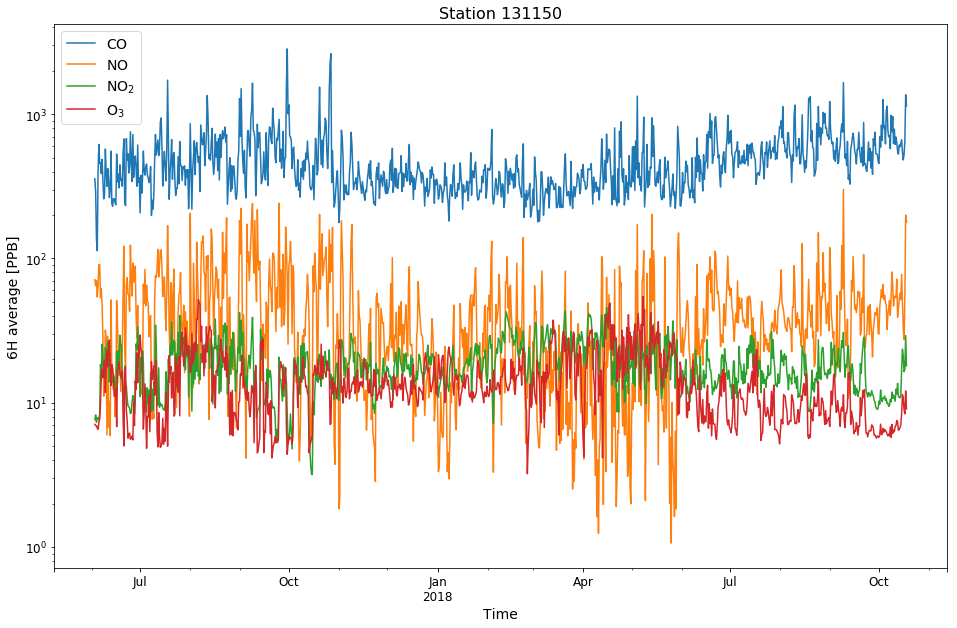

In [6]:
# figure setup
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)

# adding lines to the axis
for sl, df in sorted(dfs_resampled.items()):
    df.plot(style='-', ms=5, fontsize=12, ax=ax)

# legend and scale(s)    
ax.legend([texify[key] for key in sorted(list(dfs_resampled.keys()))], fontsize=14)
ax.set_yscale('log')

# cosmetics
ax.set_ylabel(f"{resample_rule} average [PPB]", fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_title(f"Station {stationID}", fontsize=16)


## Plotting with Plotly

In [7]:
data = []
for sl, df in sorted(dfs_resampled.items()):
    data.append(go.Scatter(x=df.index, 
                           y=getattr(df, f"{sl}_ts"),  # get data attribute of DataFrame
                           name=sl))  # latex doesn't work right now for plotly for some reason... 

# setting layout options
layout = go.Layout(showlegend=True, title=f"Station {stationID}", width=900, height=700)

# creating figure object
fig = go.Figure(data=data, layout=layout)

# cosmetics
fig.layout.yaxis.update({'title': f"{resample_rule} average [PPB]", 'type': "log"})
fig.layout.xaxis.update({'title': f"Time [steps of {resample_rule}]"})

# actual plotting
iplot(fig, image='svg', filename='station131150_CO_NO_NO2_O3')

# Forecasting
a humble approach using Facebook's Prophet package

## Temperature

In [8]:
# set the size of training data (last 10% for training)
lim = int(len(T_df_resampled['TEMP']) * 0.9)

# Prophet requires columns ds (Date) and y (value) 
train_T = T_df_resampled['TEMP'][:lim]  # set training set
test_T = T_df_resampled['TEMP'][lim:]  # set testing set
train_T = train_T.rename(columns={'TEMP_ts': 'y'})  # rename column to 'y'
train_T['ds'] = train_T.index  # rename column to 'ds'

# Make the prophet model and fit on the data using default values, but enforcing yearly seasonality
T_prophet = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
T_prophet.fit(train_T)

In [9]:
# Make a future dataframe in steps of 12H
T_forecast = T_prophet.make_future_dataframe(periods=300, freq='6H')

# Make predictions
T_forecast = T_prophet.predict(T_forecast)  # also contains historical data

### Plotting with Pandas

Text(0.5, 55.0, 'Time')

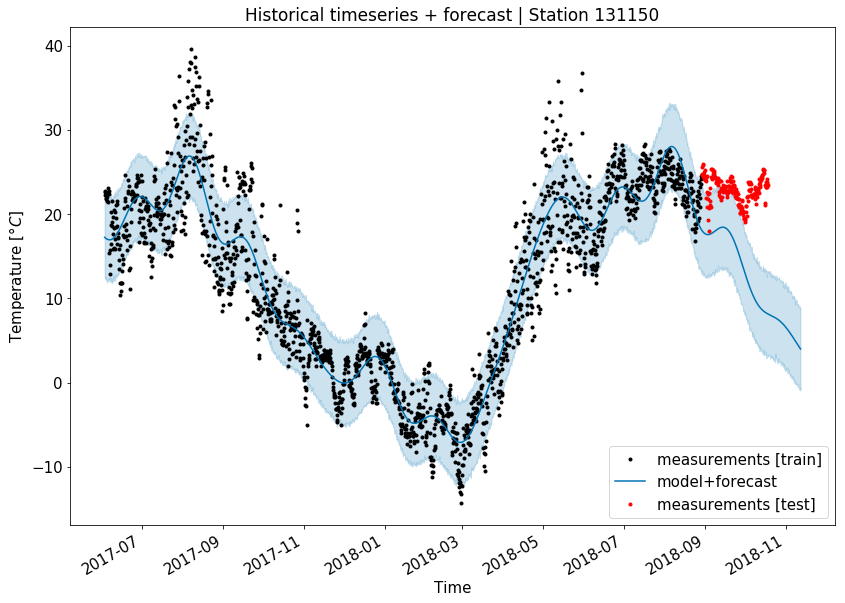

In [10]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

T_prophet.plot(T_forecast, ax=ax, xlabel="Time", ylabel="Temperature $[\\degree C]$")
test_T.plot(style='ro', ms=3, ax=ax)
leg = ax.legend(['measurements [train]', 'model+forecast', 'measurements [test]'], loc=4)
ax.set_title(f"Historical timeseries + forecast | Station {stationID}")
ax.set_xlabel("Time")  # because somehow the optional argument of prophet.Prophet.plot doesn't work

### Plotting with Plotly
since we already have the DataFrame it's gonna make things easier.. 

In [11]:
train_trace = go.Scatter(x=train_T.index, 
                         y=train_T.y,  # get data attribute of DataFrame
                         mode="markers",  # setting markers instead of lines
                         marker={'size': 4,
                                 'color': 'rgb(0, 0, 0)'},  # black
                         name="[train]")  # latex doesn't work right now for plotly for some reason... 
test_trace = go.Scatter(x=test_T.index,
                        y=test_T.TEMP_ts,
                        mode="markers",
                        marker={'size': 4,
                                'color': '#d62768'},
                        name="[test]")

# use externalised wrapper 
model = bounded_graph(T_forecast[:lim], forecast_args = {"name": "Model",
                                                         "marker": {"color": "#1F77B4"},
                                                         "line": {"width": 3}})

forecast = bounded_graph(T_forecast[lim:], forecast_args = {"name": "Forecast",
                                                         "marker": {"color": "#1F77B4"},
                                                         "line": {"width": 3,
                                                                  "dash": "dash"}})

# order of traces is very important because lower_trace has option "fill to next y": it must follow upper trace
data = [train_trace, test_trace, *model, *forecast]

# setting layout options
layout = go.Layout(showlegend=True, title=f"Historical timeseries + forecast | Station {stationID}", 
                   width=900, height=700)

# creating figure object
fig = go.Figure(data=data, layout=layout)

# cosmetics
fig.layout.yaxis.update({'title': f"{resample_rule}-average Temperature [°C]"})
fig.layout.xaxis.update({'title': f"Time [steps of {resample_rule}]"})

# actual plotting
iplot(fig, image='svg', filename='station131150_temperature')

## Gases
use $\mathsf{CO}$ as an example

In [12]:
# set the size of training data
lim = int(len(dfs_resampled['CO']) * 0.9)

# Prophet requires columns ds (Date) and y (value) 
train_df = dfs_resampled['CO'][:lim]  # set training set
test_df = dfs_resampled['CO'][lim:]  # set testing set
train_df = train_df.rename(columns={'CO_ts': 'y'})  # rename column to 'y'
train_df['ds'] = train_df.index  # rename column to 'ds'

# Make the prophet model and fit on the data using default values, but enforcing yearly seasonality
CO_prophet = prophet.Prophet(changepoint_prior_scale=0.15, yearly_seasonality=True, daily_seasonality=False, 
                             weekly_seasonality=False)
CO_prophet.fit(train_df)

# Make a future dataframe in steps of 12H
CO_forecast = CO_prophet.make_future_dataframe(periods=300, freq='12H')

# Make predictions
CO_forecast = CO_prophet.predict(CO_forecast)  # also contains historical data

### Plotting with Pandas again

Text(0.5, 55.0, 'Time')

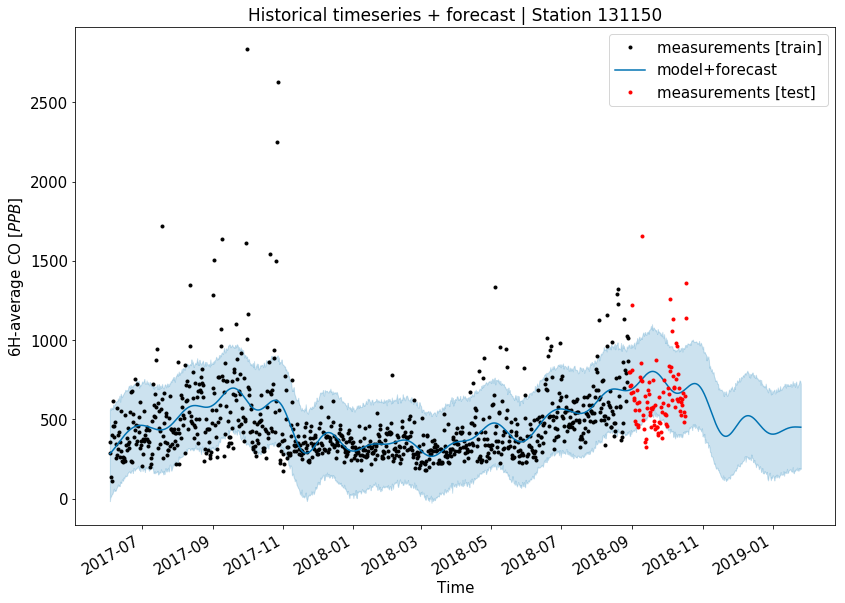

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

CO_prophet.plot(CO_forecast, ax=ax, xlabel="Time", ylabel=f"{resample_rule}-average CO $[PPB]$")
test_df.plot(style='ro', ms=3, ax=ax)
leg = ax.legend(['measurements [train]', 'model+forecast', 'measurements [test]'], loc=0)
ax.set_title(f"Historical timeseries + forecast | Station {stationID}")
ax.set_xlabel("Time")  # because somehow the optional argument of prophet.Prophet.plot doesn't work

### Plotting with Plotly again

In [24]:
train_trace = go.Scatter(x=train_df.index, 
                         y=train_df.y,  # get data attribute of DataFrame
                         mode="markers",  # setting markers instead of lines
                         marker={'size': 4,
                                 'color': 'rgb(0, 0, 0)'},  # black
                         name="[train]")  # latex doesn't work right now for plotly for some reason... 
test_trace = go.Scatter(x=test_df.index,
                        y=test_df.CO_ts,
                        mode="markers",
                        marker={'size': 4,
                                'color': '#d62768'},
                        name="[test]")

# use externalised wrapper again
model = bounded_graph(CO_forecast[:lim], forecast_args={"name": "Model",
                                                         "marker": {"color": "#1F77B4"},
                                                         "line": {"width": 3}})

forecast = bounded_graph(CO_forecast[lim-1:], forecast_args={"name": "Forecast",
                                                           "marker": {"color": "#1F77B4"},
                                                           "line": {"width": 3,
                                                                    "dash": "dash"}})

# order of traces is very important because lower_trace has option "fill to next y": it must follow upper trace
data = [train_trace, test_trace, *model, *forecast]

# setting layout options
layout = go.Layout(showlegend=True, title=f"Historical timeseries + forecast | Station {stationID}", 
                   width=900, height=700)

# creating figure object
fig = go.Figure(data=data, layout=layout)

# cosmetics
fig.layout.yaxis.update({'title': f"{resample_rule}-average CO [PPB]"})
fig.layout.xaxis.update({'title': f"Time [steps of {resample_rule}]"})

# actual plotting
iplot(fig, image='svg', filename='station131150_CO')